# Extração dos dados de TEC para as estações escolhidas
___

Os dados da série temporal para o TEC consiste de uma matriz para cada instante de tempo. Dado uma latitude e longitude é possível mapear para um par $(i, j)$ correspondendo a uma entrada da matriz. O papel deste notebook é varrer a série e extrair os dados de apenas algumas estações, isto é, dada a sua localização, é possível extrair da matriz um valor de tec. A coleção de valores extraídos ao longo do tempo, para uma dada estação, gera uma série temporal para esta.

Além da extração dos dados, uma suavização é aplicado as séries temporais encontradas.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import utils

from utils import local_data

%matplotlib inline

In [2]:
# load dataframe of stations
# load series of tec data
# load series of tec data first order derivative
# load series of tec data second order derivative

files = ['data_series_tec.pkl.xz', 'data_series_tec_first_derivative.pkl.xz', 'data_series_tec_second_derivative.pkl.xz']
df_station = pd.read_pickle(os.path.join(local_data, 'df_station.pkl'))

In [3]:
def extract_series_station_from_array(df, list_of_stations):
    data = utils.extract_vtec(df)
    # generate panda dataframe of timestamps, where there are tec information
    df_series = pd.DataFrame(index=utils.extract_index(df))
    
    for row in list_of_stations:
        i, j = utils.ij_par(row.longitude, row.latitude)
        series = [float(vtec_matrix[i][j]) for vtec_matrix in data]
        df_series[row.identificationstation] = np.array(series)
    
    return df_series

In [4]:
abs_path = os.path.join(local_data, files[0])
df_series = extract_series_station_from_array(pd.read_pickle(abs_path), df_station.itertuples())

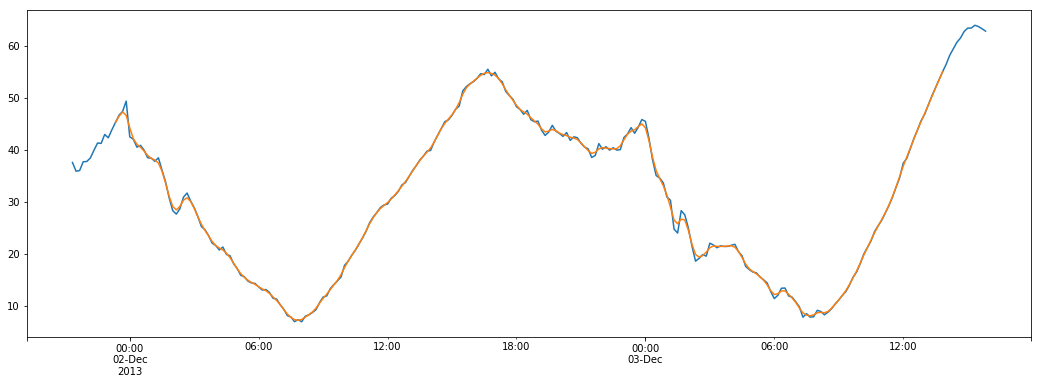

In [5]:
ax = df_series['sj2'][128:384].plot(figsize=(18, 6))
df_series['sj2'][128:384].rolling(25, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(18, 6), ax=ax);

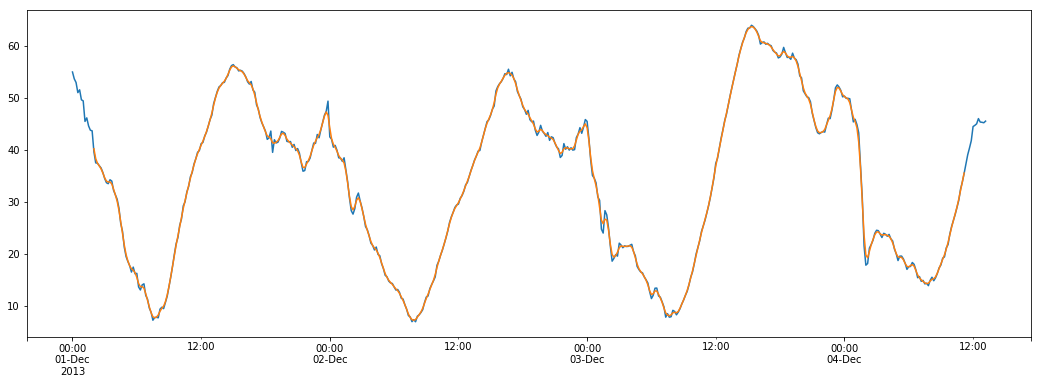

In [6]:
ax = df_series['sj2'][0:512].plot(figsize=(18, 6))
df_series['sj2'][0:512].rolling(25, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(18, 6), ax=ax);

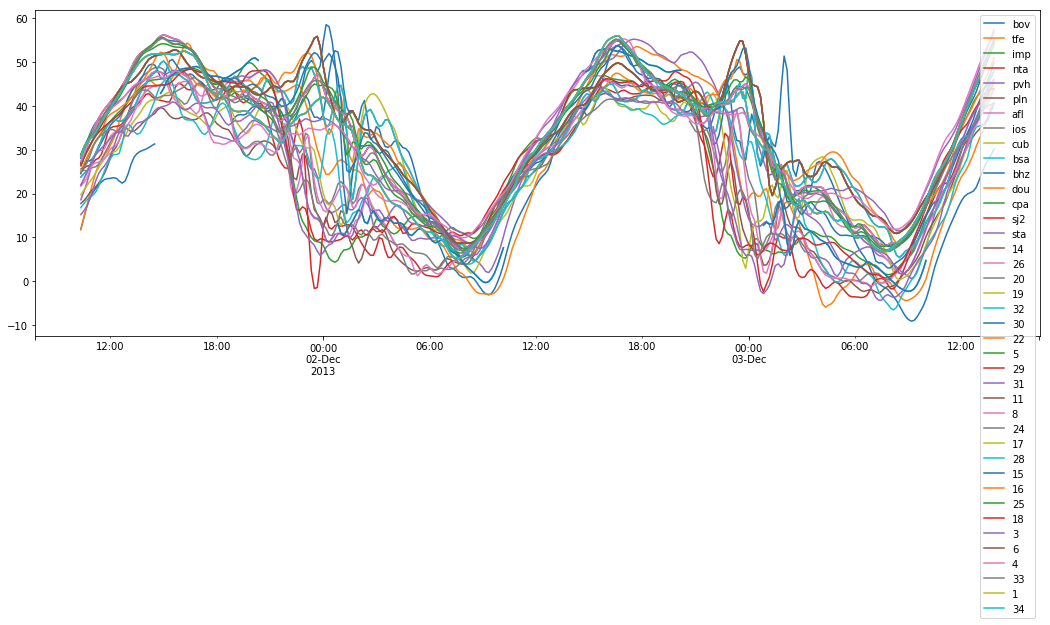

In [7]:
df_series[50:384].rolling(25, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(18, 6));

In [8]:
for file in files:
    abs_path = os.path.join(local_data, file)
    df_series = extract_series_station_from_array(pd.read_pickle(abs_path), 
                                                  df_station.itertuples())
    df_series.rolling(25, win_type='gaussian', center=True).mean(std=1.0)
    df_series.to_pickle(os.path.join(local_data, 'station_' + file))